# Gaussian Process extrapolation as probabilistic program synthesis

In [1]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

Load the read infer predict layer (ripl) and set venture's random seed to 1 to
ensure reproducibility.

In [2]:
%ripl --seed 2 --plugins plugins.py

Set seed of a new VentureScript RIPL to 2.00.
Loading plugin: plugins.py


In [3]:
%%venturescript
// MODEL
assume x_min = 0.; // minimum of observed input 
assume x_max = 10.6; // maximum of observed input 
assume y_max = 278.7; // maximum of observed output
assume get_hyper_prior ~ mem((node_index) -> {
    if (node_index[0] == "WN" or node_index[0] == "C") {
        // Sample hyper-priors ranging over the y axis.
        uniform_continuous(x_min, y_max) #hypers:node_index
    } else {
        // Sample hyper-priors ranging over the x axis.
        uniform_continuous(0, x_max) #hypers:node_index
    }
});
assume get_tree_root = () -> {1.0};
assume get_base_kernel_index ~ mem((node_index) -> {
    uniform_discrete(0,5) #structure:node_index
});
assume choose_primitive =  (node_index) -> {
    rolled_dice = get_base_kernel_index(node_index);
    cond(
        (rolled_dice == 0)
            ([
                "WN",
                 get_hyper_prior(pair("WN", node_index))
            ]),
        (rolled_dice == 1)
            ([
                "C",
                 get_hyper_prior(pair("C", node_index))
            ]),
        (rolled_dice == 2)
            ([
                "LIN",
                 get_hyper_prior(pair("LIN", node_index))
            ]),
        (rolled_dice == 3)
            ([
                "SE",
                0.01 + get_hyper_prior(pair("SE", node_index))
            ]),
        (rolled_dice == 4)
            ([
                "PER",
                0.01 + get_hyper_prior(pair("PER_l", node_index)),
                0.01 + get_hyper_prior(pair("PER_t", node_index))
            ]),
    else("error"))
};
assume choose_operator = mem((node_index) -> {
    operator_symbol ~ categorical(
        simplex(0.45, 0.45, 0.1),
        ["+", "*", "CP"]
    ) #structure:pair("operator", node_index);
    if (operator_symbol == "CP") {
        [
            operator_symbol,
            get_hyper_prior(pair("CP", node_index))
        ]
    } else {
        operator_symbol
    }
});
assume generate_random_program = mem((node_index) -> {
    if (flip(0.3) #structure:pair("branch", node_index)) {
        operator ~ choose_operator(node_index);
        [
            operator,
            generate_random_program(2 * node_index),
            generate_random_program((2 * node_index + 1))
        ]
    } else {
        choose_primitive(node_index)
    }
});
assume source ~ generate_random_program(get_tree_root()) #GP;
assume produce_covariance = (source) -> {
    cond(
        (source[0] == "WN") (
                gp_cov_scale(
                    source[1],
                    gp_cov_bump(0.000000001, 0.00000000001)
                )
            ),
        (source[0] == "C")
            (
                gp_cov_const(source[1])
            ),
        (source[0] == "LIN")
            (
                gp_cov_linear(source[1])
            ),
        (source[0] == "SE")
            (
                gp_cov_se(source[1]**2)
            ),
        (source[0] == "PER")
            (
                gp_cov_periodic(source[1]**2, source[2])
            ),
        (source[0] =="+")
            (
                gp_cov_sum(
                    produce_covariance(source[1]),
                    produce_covariance(source[2])
                )
            ),
        (source[0] =="*")
            (
                gp_cov_product(
                    produce_covariance(source[1]),
                    produce_covariance(source[2])
                )
            ),
        (source[0][0] =="CP")
            (
                gp_cov_cp(
                    source[0][1],
                    0.1, // scale of change point.
                    produce_covariance(source[1]),
                    produce_covariance(source[2])
                )
            ),
    else("error"))
};
assume baseline_noise_var = 0.01; 
assume produce_executable = (source) -> {
    baseline_noise = gp_cov_scale(
        baseline_noise_var,
        gp_cov_bump(0.000000001, 0.00000000001)
    );
    covariance_kernel = gp_cov_sum(produce_covariance(source), baseline_noise);
    make_gp(gp_mean_const(0.), covariance_kernel)
};
assume gp = produce_executable(source);

## 4. Observe data 
The `${}` syntax in `${observed_input}` causes the observed input defined in the global scope to be spliced into the modeling scope.

In [4]:
%%venturescript
// OBSERVATIONS
// Load data.
define observed_input  = load_csv(str_concat(get_path(), "/airline-data/x_training.csv"));
define observed_output = load_csv(str_concat(get_path(), "/airline-data/y_training.csv"));
define test_input  = load_csv(str_concat(get_path(), "/airline-data/x_test.csv"));
define test_output = load_csv(str_concat(get_path(), "/airline-data/y_test.csv"));
observe gp(${observed_input}) = observed_output;

## 5. Inference

In [5]:
%%venturescript
// INFERENCE
define single_site_mh = () -> {
    mh(minimal_subproblem(random_singleton(/ *)), 1)    
};
define resimulation_mh = () -> {
    mh(default, all, 1)    
};
// Helper for plotting and sampling
define number_of_curves = 100;

#### GP posterior predictive.

In [6]:
%%venturescript
mh(minimal_subproblem(random_singleton(/ *)), 2000)

[41.687]

In [7]:
%%venturescript
define x_input = linspace(0.0001, 13, 100);
define gp_posterior_predictive = mapv(
    (_) -> {run(sample(gp(${x_input})))},
    arange(number_of_curves)
);

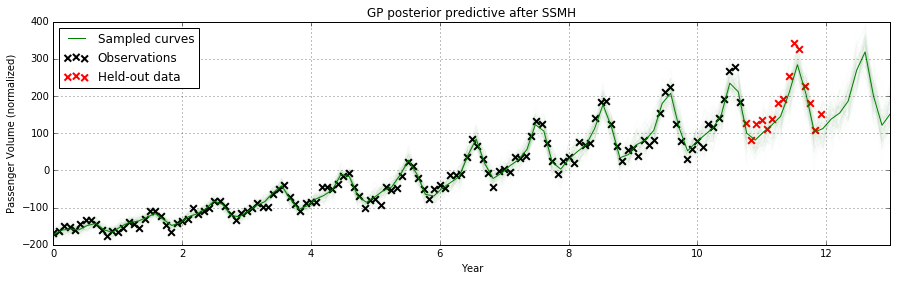

In [13]:
%%venturescript
define plotting_args_scatter = dict(
        ["xlabel", "Year"],
        ["ylabel", "Passenger Volume (normalized)"],
        ["label", "Observations"],
        ["title", "Training data"],
        ["markersize", 45],
        ["width", 15],
        ["height", 4],
        ["color", "black"]
);
define plotting_args_curves = dict(
    ["xlabel", "Year"],
    ["ylabel", "Passenger Volume (normalized)"],
    ["title", "GP posterior predictive after SSMH"],
    ["label", "Sampled curves"],
    ["width", 15],
    ["height", 4],
    ["alpha", 0.01],
    ["color", "green"],
    ["xlim", [0, 13]],
    ["ylim", [-200, 400]]
);
scatter_plot(observed_input, observed_output, plotting_args_scatter);
define plotting_args_scatter_test_data = dict(
        ["markersize", 45],
        ["color", "red"],
        ["label", "Held-out data"]
);
scatter_plot(test_input, test_output, plotting_args_scatter_test_data);
for_each(
    arange(number_of_curves),
    (i) -> {
        action(
            line_plot(
                x_input, 
                lookup(gp_posterior_predictive, i),
                plotting_args_curves

            )
        )
    } 
);
line_plot(x_input, get_predictive_mean(gp_posterior_predictive));
legend("upper left");

In [9]:
%%venturescript
reset_to_prior;

In [10]:
%%venturescript
repeat(2000, resimulation_mh());

In [11]:
%%venturescript
define x_input = linspace(0.0001, 13, 100);
define gp_posterior_predictive_resimulation = mapv(
    (_) -> {run(sample(gp(${x_input})))},
    arange(number_of_curves)
);

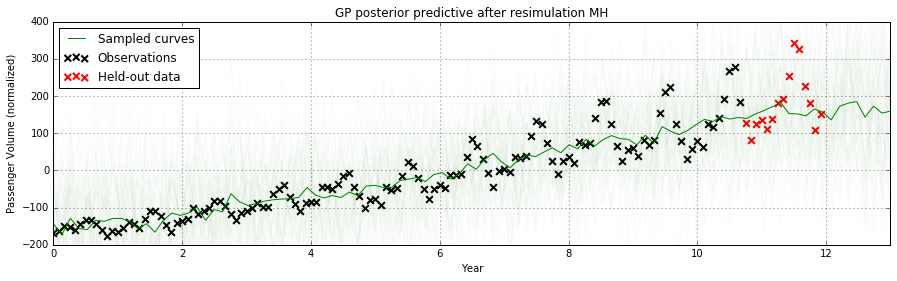

In [14]:
%%venturescript
scatter_plot(observed_input, observed_output, plotting_args_scatter);
define plotting_args_scatter_test_data = dict(
        ["markersize", 45],
        ["color", "red"],
        ["label", "Held-out data"]
);
scatter_plot(test_input, test_output, plotting_args_scatter_test_data);
for_each(
    arange(number_of_curves),
    (i) -> {
        action(
            line_plot(
                x_input, 
                lookup(gp_posterior_predictive_resimulation, i),
                plotting_args_curves

            )
        )
    } 
);
define plotting_title = dict(
        ["title", "GP posterior predictive after resimulation MH"]
);
line_plot(x_input, get_predictive_mean(gp_posterior_predictive_resimulation), plotting_title);
legend("upper left");